In [3]:
import os
import json
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import random

# Define the Pose Estimation Model
class PoseEstimationNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoseEstimationNet, self).__init__()
        # Define the architecture
        self.fc1 = nn.Linear(input_size, 1024)  # First linear layer
        self.bn1 = nn.BatchNorm1d(1024)  # Batch normalization for the first layer
        self.dropout1 = nn.Dropout(0.5)  # Dropout to prevent overfitting
        
        # Additional layers can be added here
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, output_size)  # Final layer to output size

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  # Apply ReLU activation function after batch normalization
        x = self.dropout1(x)  # Apply dropout
        
        # Additional layers
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.fc3(x)  # No activation function is used at the output layer
        return x

        
# Custom Dataset Class
class SpotDataset(Dataset):
    def __init__(self, images_dir, mapping_2d_dir, mapping_3d_dir, transform=None, split_ratio=0.8, split='train'):
        self.transform = transform
        
        filenames = [os.path.basename(x) for x in glob.glob(os.path.join(images_dir, '*.png'))]
        random.shuffle(filenames)
        split_index = int(len(filenames) * split_ratio)
        
        if split == 'train':
            self.filenames = filenames[:split_index]
        else:  # 'val'
            self.filenames = filenames[split_index:]
        
        self.images_dir = images_dir
        self.mapping_2d_dir = mapping_2d_dir
        self.mapping_3d_dir = mapping_3d_dir

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.filenames[idx])
        image = Image.open(img_name)

        mapping_2d_name = os.path.join(self.mapping_2d_dir, self.filenames[idx].replace('.png', '.json'))
        with open(mapping_2d_name) as f:
            mapping_2d = json.load(f)
        keypoints_2d = [kp['position'] for kp in mapping_2d['keypoints']]
        keypoints_2d = np.array([(kp['x'], kp['y']) for kp in keypoints_2d]).flatten()

        mapping_3d_name = os.path.join(self.mapping_3d_dir, self.filenames[idx].replace('.png', '.json'))
        with open(mapping_3d_name) as f:
            mapping_3d = json.load(f)
        keypoints_3d = [kp['position'] for kp in mapping_3d['poses']]
        keypoints_3d = np.array([(kp['x'], kp['y'], kp['z']) for kp in keypoints_3d]).flatten()

        sample = {'image': image, 'keypoints_2d': keypoints_2d, 'keypoints_3d': keypoints_3d}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['keypoints_2d'] = torch.tensor(sample['keypoints_2d'], dtype=torch.float32)
            sample['keypoints_3d'] = torch.tensor(sample['keypoints_3d'], dtype=torch.float32)

        return sample

# Transform for image data
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create the Dataset and DataLoader
train_dataset = SpotDataset(
    images_dir='C:/Users/sakar/Semester Project/Spot Datasets/99 - Transformer/images',
    mapping_2d_dir='C:/Users/sakar/Semester Project/Spot Datasets/99 - Transformer/mapping_2d',
    mapping_3d_dir='C:/Users/sakar/Semester Project/Spot Datasets/99 - Transformer/mapping_3d',
    split='train',
    transform=transform
)

val_dataset = SpotDataset(
    images_dir='C:/Users/sakar/Semester Project/Spot Datasets/99 - Transformer/images',
    mapping_2d_dir='C:/Users/sakar/Semester Project/Spot Datasets/99 - Transformer/mapping_2d',
    mapping_3d_dir='C:/Users/sakar/Semester Project/Spot Datasets/99 - Transformer/mapping_3d',
    split='val',
    transform=transform
)

# And create DataLoaders for each
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"Size of training set: {len(train_dataset)}")
print(f"Size of validation set: {len(val_dataset)}")

# Define the model, loss function, and optimizer
model = PoseEstimationNet(input_size=26, output_size=39)  # Adjust both input and output sizes
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 30 # Set the number of epochs

model_save_path = "C:/Users/sakar/Semester Project/simple-effective.pth"  # Path to save the model

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs} started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Training phase
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        keypoints_2d = data['keypoints_2d']
        keypoints_3d = data['keypoints_3d']
        
        optimizer.zero_grad()
        outputs = model(keypoints_2d)
        loss = criterion(outputs, keypoints_3d)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            keypoints_2d = data['keypoints_2d']
            keypoints_3d = data['keypoints_3d']
            outputs = model(keypoints_2d)
            loss = criterion(outputs, keypoints_3d)
            val_loss += loss.item()
    
    val_loss /= len(val_dataloader)
    print(f"Validation Loss: {val_loss:.4f}")

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Size of training set: 4008
Size of validation set: 1002

Epoch 1/30 started at 2024-02-21 15:42:44
Training Loss: 0.8590
Validation Loss: 0.5575

Epoch 2/30 started at 2024-02-21 15:44:34
Training Loss: 0.6544
Validation Loss: 0.4792

Epoch 3/30 started at 2024-02-21 15:46:19
Training Loss: 0.6468
Validation Loss: 0.3428

Epoch 4/30 started at 2024-02-21 15:48:04
Training Loss: 0.6202
Validation Loss: 0.2732

Epoch 5/30 started at 2024-02-21 15:49:49
Training Loss: 0.6181
Validation Loss: 0.4221

Epoch 6/30 started at 2024-02-21 15:51:34
Training Loss: 0.6087
Validation Loss: 0.4052

Epoch 7/30 started at 2024-02-21 15:53:20
Training Loss: 0.5842
Validation Loss: 0.3744

Epoch 8/30 started at 2024-02-21 15:55:05
Training Loss: 0.5757
Validation Loss: 0.2506

Epoch 9/30 started at 2024-02-21 15:56:49
Training Loss: 0.5525
Validation Loss: 0.3821

Epoch 10/30 started at 2024-02-21 15:58:34
Training Loss: 0.5730
Validation Loss: 0.3607

Epoch 11/30 started at 2024-02-21 16:00:18
Training 

In [3]:
import os
import json
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import random
import numpy as np

class PoseEstimationNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoseEstimationNet, self).__init__()
        # Define the architecture
        self.fc1 = nn.Linear(input_size, 1024)  # First linear layer
        self.bn1 = nn.BatchNorm1d(1024)  # Batch normalization for the first layer
        self.dropout1 = nn.Dropout(0.5)  # Dropout to prevent overfitting
        
        # Additional layers can be added here
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, output_size)  # Final layer to output size

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  # Apply ReLU activation function after batch normalization
        x = self.dropout1(x)  # Apply dropout
        
        # Additional layers
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.fc3(x)  # No activation function is used at the output layer
        return x
    
def load_model(model_path, input_size, output_size):
    model = PoseEstimationNet(input_size, output_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

def prepare_input(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    keypoints_2d = [kp['position'] for kp in data['keypoints']]
    keypoints_2d = np.array([(kp['x'], kp['y']) for kp in keypoints_2d]).flatten()
    return torch.tensor([keypoints_2d], dtype=torch.float32)  # Add a batch dimension

def predict_3d_keypoints(model, input_tensor):
    with torch.no_grad():
        outputs = model(input_tensor)
    return outputs.numpy()

# Load the model
model_path = "C:/Users/sakar/Semester Project/simple-effective.pth"
model = load_model(model_path, input_size=26, output_size=39)

# Prepare the input
json_path = "C:/Users/sakar/Semester Project/Spot Datasets/13 - 2 Spots/test/mapping_2d/1000.json"
input_tensor = prepare_input(json_path)

# Predict 3D keypoints
predicted_3d_keypoints = predict_3d_keypoints(model, input_tensor)
print(predicted_3d_keypoints)

[[-1.5591471  -0.30193433  6.1397963  -1.8592938  -0.24318022  6.1727476
  -1.9772259  -0.8014172   5.731722   -1.8956662  -1.2633294   6.293816
  -1.2547125  -0.36705074  6.1026793  -1.4230515  -0.8610119   5.638835
  -1.3445406  -1.3027031   6.2062874  -2.0620778  -0.3037933   4.993357
  -2.1575704  -0.8530211   4.518442   -2.1161535  -1.2767684   5.0802183
  -1.4797517  -0.4315889   4.9214664  -1.6573354  -0.9937098   4.477658
  -1.5866008  -1.4180639   5.0460763 ]]


C:\Users\sakar\AppData\Local\Temp\ipykernel_7268\1219544528.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor([keypoints_2d], dtype=torch.float32)  # Add a batch dimension


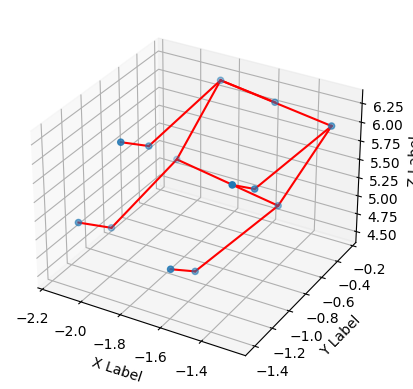

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the pairs of keypoints to connect
keypoint_pairs = [
    (0, 1), (1, 4), (1, 7), (7, 10), (4, 10),
    (1, 2), (2, 3), (4, 5), (5, 6), (7, 8),
    (8, 9), (10, 11), (11, 12)
]

def plot_3d_keypoints(keypoints):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = keypoints[:, 0]
    ys = keypoints[:, 1]
    zs = keypoints[:, 2]

    ax.scatter(xs, ys, zs)
    
    # Draw lines between specified keypoints
    for pair in keypoint_pairs:
        x_pair = [keypoints[pair[0], 0], keypoints[pair[1], 0]]
        y_pair = [keypoints[pair[0], 1], keypoints[pair[1], 1]]
        z_pair = [keypoints[pair[0], 2], keypoints[pair[1], 2]]
        ax.plot(x_pair, y_pair, z_pair, 'r')

    # Labeling axes (optional)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

# Assuming predicted_3d_keypoints is a (N, 3) NumPy array
predicted_3d_keypoints = predicted_3d_keypoints.reshape(-1, 3)  # Adjust shape if needed
plot_3d_keypoints(predicted_3d_keypoints)
